[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ai2es/WAF_ML_Tutorial_Part2/blob/main/MOOC_Notebooks/Notebook02_Explore_sub_sevir.ipynb)

# Notebook 02: Explore sub-sevir

Authors: Randy J. Chase, David R. Harrison, Gary M. Lackmann, and Amy McGovern<br>
Institution: [AI2ES](https://www.ai2es.org)<br>
Associated paper: [A Machine Learning Tutorial for Operational Meteorology, Part II: Neural Networks and Deep Learning](https://arxiv.org/abs/2211.00147)<br>
Original Github: [WAF_ML_Tutorial_Part2](https://github.com/ai2es/WAF_ML_Tutorial_Part2)

If you use this code or data in your work, please cite the paper: 

Chase, R. J., Harrison, D. R., Lackmann, G. M., & McGovern, A. (2023). A Machine Learning Tutorial for Operational Meteorology. Part II: Neural Networks and Deep Learning, 	arXiv:2211.00147.


### Primary Goal: Play around and get familar with sub-sevir 

#### Background

I always encourage people to get to know the data they are using for machine learning. So here, we will visualize some of the sub-sevir data. This is an important concept because the more comforatable you are with your data, the better you can anticipate when things will fail. 

#### Step 1: Install some things and grab the data

We need to install some dependencies and download the dataset to this. This next cell should be hidden, but if you want to look in there go ahead. Please run this cell before continuing. 

Note: downloading the data can take up to 15-20 mins depending on the server speed. Please be patient

In [ ]:
#@title Install and unpack files [this will take some time]

print('installing dependancies')
!pip -q install zenodo-get
!pip -q install zarr 
!pip -q install xmovie
print('grabbing sub-sevir')
!zenodo_get 7011372
print('unpacking sub-sevir')
!tar -xf sub-sevir.tar.gz
!tar -xf sub-sevir/sub-sevir-train.tar.gz -C sub-sevir/
!tar -xf sub-sevir/sub-sevir-val.tar.gz -C sub-sevir/
!tar -xf sub-sevir/sub-sevir-test.tar.gz -C sub-sevir/
print('grabbing the Github repo')
!git clone https://github.com/ai2es/WAF_ML_Tutorial_Part2.git
print('done')

In [1]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'


#### Step 2: load some data
The data format here is called [Zarr](). I know, it's kinda a bizarre name, but it's a newer file format that is popular for cloud (not weather clouds, but the computer cloud kind) computing. 

I chose this format because: 

1. It gives you some exposure to the new file format

       You will see shortly that we will use these files no differently than a netCDF4. Xarray presents them in the same exact manner. 



2. They are very nice for file compression 

        It was a goal of mine to make this dataset small but powerful. So a file format that compresses nicely worked better here. 
       
       
This next code block just loads the file and prints out the metadata. 

In [6]:
ds_train = xr.open_dataset('sub-sevir/sub-sevir-train.zarr',engine='zarr')

#print out the dataset 
ds_train

<xarray.Dataset>
Dimensions:         (n_samples: 60000, x: 48, y: 48, n_channel: 4)
Coordinates:
    id              (n_samples) object ...
  * n_channel       (n_channel) <U5 'ir069' 'ir107' 'vil' 'vis'
  * n_samples       (n_samples) datetime64[ns] 2018-08-25T00:15:00 ... 2019-0...
Dimensions without coordinates: x, y
Data variables:
    features        (n_samples, x, y, n_channel) float32 ...
    label_1d_class  (n_samples) int8 ...
    label_1d_reg    (n_samples) int16 ...
    label_2d_class  (n_samples, x, y) int8 ...
    label_2d_reg    (n_samples, x, y) int16 ...

Here are the variables in this file:

1. features 
        
        These are the features for machine learning. In other words these are the inputs. They are of shape [n_samples, nx, ny, n_channel]. n_channel are the various inputs to the model, ordered as: water vapor, infrared, vertically integrate liquid, and visible.
        
2. label_ ... 

        These are all the various labels. In other words the outputs of the machine learning. You see there are 4 different kinds here: _1d_, _2d_, _class and _reg. The 1d has to do with the 1 dimensional tasks (the traditional machine learning methods and the artifical neural networks) and the 2 dimensional tasks (U-net). The _class labels are for classification tasks and _reg is for regression. 


As you can hopefully see here, there are 60,0000 images in this dataset - plenty of examples to train a neural network on. But for now, let's take a look at just one sample. 

Xarray has some cool built-in methods that let you slice and dice the data quickly. Say for example we wanted to look at sample number 42. We can easily do this with the ```.isel``` method which *selects* the data off of the *index*:  

In [10]:
ds_sample = ds_train.isel(n_samples=42)

#print it out:
ds_sample

<xarray.Dataset>
Dimensions:         (x: 48, y: 48, n_channel: 4)
Coordinates:
    id              object 'R18071205068701'
  * n_channel       (n_channel) <U5 'ir069' 'ir107' 'vil' 'vis'
    n_samples       datetime64[ns] 2018-07-12T01:05:00
Dimensions without coordinates: x, y
Data variables:
    features        (x, y, n_channel) float32 ...
    label_1d_class  int8 1
    label_1d_reg    int16 476
    label_2d_class  (x, y) int8 ...
    label_2d_reg    (x, y) int16 ...

Since we only selected 1 sample, you can see how the n_samples dimension is now empty. I have provided a function for you to plot this sample in the code block below:

In [11]:
#define function 
def show_sample(ds):
    
    #define figure with 1 row and 5 columns. 
    fig,axes = plt.subplots(1,5,figsize=(15,7.5))
    #set the background to white, for some reason its transparent
    fig.set_facecolor('w')
    #choose some colormaps for drawing
    cmaps = ['Blues','turbo','Spectral_r','Greys_r']
    #loop over features (inputs)
    for i,ax in enumerate(axes[0:4]):
        #plot images
        ax.imshow(ds.features[:,:,i],cmap=cmaps[i])
        ax.axis('off')
        ax.set_title(ds.n_channel[i].values)

    #plot labels (output) which is GLM 
    ax = axes[4]
    ax.imshow(np.log10(ds.label_2d_reg[:,:]),cmap='magma')
    ax.axis('off')
    ax.set_title('glm')

    fig.suptitle('class label: {}, n flashes: {}'.format(ds.label_1d_class.values,ds.label_1d_reg.values),y=0.75)

    return ds.id.values

/Users/randyjc2/miniconda3/envs/waf_tutorial_part2/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


array('R18071205068701', dtype=object)

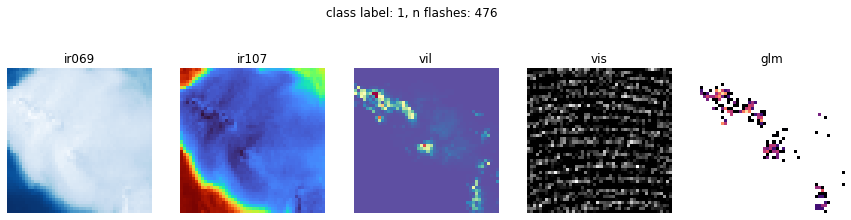

In [12]:
show_sample(ds_sample)

This example is centered on a deep convective storm, but notice that the visible channel does not seem to align with the other data. This is not a bug, but rather this sample is of a storm at night. Without any sunlight to illumiate the clouds, the visible channel mostly contains noise.  To get the time of an image you can do the following:

In [15]:
ds_sample.n_samples

<xarray.DataArray 'n_samples' ()>
array('2018-07-12T01:05:00.000000000', dtype='datetime64[ns]')
Coordinates:
    id         object 'R18071205068701'
    n_samples  datetime64[ns] 2018-07-12T01:05:00

These are datetimes, which are of the format:
'Year-Month-Day Hour:Minute:second'

Also note these times are in UTC, so this storm occurred just past sunset at this location.

Now, look again at the cell with the image. You will see an output saying 'array('R19071205068701')', which is the SEVIR id number from the original dataset. This is important because in these files are 11 other time steps of the same scene. So we could potentially grab all events from the same scene (but with different time steps over the entire hour). 

We will leverage the xarray ```.groupby``` function to get all the other scenes. Note these scenes are not in order of event but in order of time, so there is a chance that scenes are not spatially next to each other. 

In [16]:
#this function returns the indices of the group
def get_group_idx(group_string,ds):
    return ds.groupby('id').groups[group_string]

#this function returns all the possible groups. 
def get_groups(ds):
    return list(ds.groupby('id').groups.keys())

In [18]:
storm_idx = get_group_idx(str(ds_sample.id.values),ds_train)
ds_sample_scene = ds_train.isel(n_samples=storm_idx)
ds_sample_scene

<xarray.Dataset>
Dimensions:         (n_samples: 12, x: 48, y: 48, n_channel: 4)
Coordinates:
    id              (n_samples) object 'R18071205068701' ... 'R18071205068701'
  * n_channel       (n_channel) <U5 'ir069' 'ir107' 'vil' 'vis'
  * n_samples       (n_samples) datetime64[ns] 2018-07-12T00:35:00 ... 2018-0...
Dimensions without coordinates: x, y
Data variables:
    features        (n_samples, x, y, n_channel) float32 ...
    label_1d_class  (n_samples) int8 1 1 1 1 1 1 1 1 1 1 1 1
    label_1d_reg    (n_samples) int16 200 281 268 240 273 ... 386 782 392 341
    label_2d_class  (n_samples, x, y) int8 ...
    label_2d_reg    (n_samples, x, y) int16 ...

The dataset should now have 12 samples. 

We can visualize these 12 samples in 12 cells, or we can use an opensource code set called xarray-movie (xmovie). 

See the code below:

In [20]:
from xmovie import Movie

def custom_plotfunc(ds, fig, tt, *args, **kwargs):
    """ This is a custom plot function built for xmoive. """
    #select time step tt 
    ds_tmp = ds.isel(n_samples=tt)
    
    #make plots 
    axes = fig.subplots(ncols=5)
    
    #define colormaps
    cmaps = ['Blues','turbo','Spectral_r','Greys_r']
    #define lower color bound 
    vmins = [-3,-2.25,0,-1]
    #define upper color bound
    vmaxs = [2,2,20,2]

    #loop over axes 
    for i,ax in enumerate(axes[0:4]):
      ax.imshow(ds_tmp.features[:,:,i],cmap=cmaps[i],vmin=vmins[i],vmax=vmaxs[i])
      ax.axis('off')
      ax.set_title(ds_tmp.n_channel[i].values,fontsize=5)

    #plot lightning
    ax = axes[4]
    ax.imshow(np.log10(ds_tmp.label_2d_reg[:,:]),cmap='magma')
    ax.axis('off')
    ax.set_title('glm',fontsize=4)
    
    #add title with label, number of flashes and time. 
    fig.suptitle('class label: {}, n flashes: {}, time: {}'.format(ds_tmp.label_1d_class.values,
                                                                   ds_tmp.label_1d_reg.values,
                                                                   ds_tmp.n_samples.dt.strftime('%Y-%m-%d %H:%M').values),
                 y=1,fontsize=5)

    return None, None

/Users/randyjc2/miniconda3/envs/waf_tutorial_part2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's go ahead and make the movie now

In [22]:
mov_custom = Movie(ds_sample_scene, custom_plotfunc,input_check=False,framedim='n_samples',pixelwidth=1000, pixelheight=500, dpi=500)
mov_custom.save('./movie.mp4', progress=True,overwrite_existing=True)

/Users/randyjc2/miniconda3/envs/waf_tutorial_part2/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
100%|███████████████████████████████████████████| 12/12 [00:05<00:00,  2.07it/s]


Movie created at movie.mp4


There ya go! We have made a movie. Go ahead and play it. 

Dont worry about the code in the next cell, it's just to get the video to play here in the notebook.

In [24]:
#@title view movie 
from IPython.display import HTML
from base64 import b64encode

video_path = "./movie.mp4"

mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=800 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")

Data always looks better in motion. Now you might be asking, Randy why is the visible channel now blank? This is because we modified the color scale so that we can see clouds in the daytime without the image being completely white. 

I encourage you to go pick out some more scenes and play around. I hope you find some fun examples. 

In the next notebook, we will finally dive into some machine learning. 